In [14]:
import pandas as pd
import time 
import json
import urllib.request
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from pandas.io.json import json_normalize
from joblib import Parallel, delayed

## Importing RPi JSON Data to DataFrame

In [15]:
df = pd.read_json("https://alte-rs.ddnss.de/weather/processed/history.json")
df['time'] = pd.to_datetime(df['time'])
df['temp'] = pd.to_numeric(df['temp'])
df['pressure'] = pd.to_numeric(df['pressure'])
df['humidity'] = pd.to_numeric(df['humidity'])
dataframe_rpi = df.set_index('time')
dataframe_rpi.head()

,humidity,pressure,temp
time,,,
2018-06-22 16:20:01.656,36.116451,1025.179932,28.907051
2018-06-22 16:20:40.606,35.238693,1025.148682,28.870728
2018-06-22 16:21:19.756,35.684219,1025.106445,28.852566
2018-06-22 16:21:58.636,35.843815,1025.139404,28.907051
2018-06-22 16:22:37.505,36.053280,1025.058105,28.870728


## Smoothing RPi Data

### Rolling Sums

In [16]:
window_length='10min'
min_data_points=2
dataframe_rpi_rolling = dataframe_rpi.rolling(window=window_length,min_periods=min_data_points).mean()
dataframe_rpi_rolling.isnull().sum()

humidity    3
pressure    3
temp        3
dtype: int64

### Resampling

In [17]:
dataframe_rpi_resampled = dataframe_rpi.resample('10min').mean()
dataframe_rpi_resampled.head()


,humidity,pressure,temp
time,,,
2018-06-22 16:20:00,35.945014,1025.128479,28.848024
2018-06-22 16:30:00,37.939356,1025.207389,28.233832
2018-06-22 16:40:00,38.689470,1025.248001,28.132880
2018-06-22 16:50:00,40.754175,1025.261621,27.952921
2018-06-22 17:00:00,40.971620,1025.250163,28.095798


## Importing OWM Data

In [18]:
with urllib.request.urlopen("https://alte-rs.ddnss.de/weather/processed/history_owm.json") as url:
    data = json.loads(url.read().decode())
init_table = json_normalize(data)
weather_descr = json_normalize(data,record_path=['weather'],record_prefix='weather.')
temp = init_table.join(weather_descr)
temp['time'] = pd.to_datetime(temp['dt'],unit='s')
temp['temp'] = pd.to_numeric(temp['main.temp'])-273.15
temp['humidity'] = pd.to_numeric(temp['main.humidity'])
temp['pressure'] = pd.to_numeric(temp['main.pressure'])
dataframe_owm = temp.set_index('time')
dataframe_owm_resampled = dataframe_owm[['temp','pressure','humidity']].resample('30min').mean()
dataframe_owm_resampled.head()

,temp,pressure,humidity
time,,,
2018-06-16 20:30:00,17.509474,1013.0,77.0
2018-06-16 21:00:00,18.010000,1013.0,77.0
2018-06-16 21:30:00,18.010000,1013.0,77.0
2018-06-16 22:00:00,17.506667,1013.0,77.0
2018-06-16 22:30:00,17.000000,1013.0,82.0


## Creating Feature Matrix and Prediction Vector

### Reducing the input values to a maxmimum of one row every 5min

In [19]:
time_step = timedelta(minutes = 5)
init = dataframe_rpi_rolling.index[0]

for time in dataframe_rpi_rolling.index:
    if time-init > time_step:
        init = time
    else:
        dataframe_rpi_rolling = dataframe_rpi_rolling.drop(time)
dataframe_rpi_rolling.head()

,humidity,pressure,temp
time,,,
2018-06-22 16:25:30.796,35.743404,1025.125806,28.879808
2018-06-22 16:30:44.135,36.051825,1025.124542,28.802618
2018-06-22 16:36:02.356,37.181235,1025.162430,28.506343
2018-06-22 16:41:20.815,38.239161,1025.227509,28.176015
2018-06-22 16:46:39.475,38.701938,1025.252014,28.105636


### Creating prediction matrix y 

In [20]:
prediction_steps = 20
history_steps = 20

y = dataframe_rpi_resampled[ prediction_steps + history_steps :]
y_index = dataframe_rpi_resampled[ prediction_steps + history_steps :].index

length = len(y)
print(y.shape)
print(np.isnan(y).sum())

(4251, 3)
humidity    561
pressure    561
temp        561
dtype: int64


### Creating input matrix x, which contains 20 consequtive historical values (time steps)

In [21]:
x = np.empty((length,60))

def xrow (start):
    return dataframe_rpi_resampled[ start : start + history_steps ].values.flatten();

for n in  range(0,length):
    x[n] =xrow(n)
print(x.shape)
print(np.isnan(x).sum())

(4251, 60)
33660


## Using Imputer to get rid of NaNs


In [32]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(x)
x_imputer = imputer.transform(x)
imputer = imputer.fit(y)
y_imputer = pd.DataFrame(data=imputer.transform(y), columns=['humidity','pressure','temp'], index=y_index)

y_imputer.shape

(4251, 3)

## Splitting up into training and testing

In [33]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size = 1/3, random_state = 0)
cut=3000
y_train = y_imputer[0:cut]
x_train = x_imputer[0:cut]
y_test = y_imputer[cut:]
x_test = x_imputer[cut:]


## Scaling the features

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.fit_transform(x_test)

## Learning with linear regression

In [35]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression(n_jobs=-1)
regressor.fit(x_train_sc, y_train['temp'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [36]:
y_test_pred = pd.DataFrame(data=regressor.predict(x_test), index=y_test.index)
y_train_pred = pd.DataFrame(data=regressor.predict(x_train), index=y_train.index)

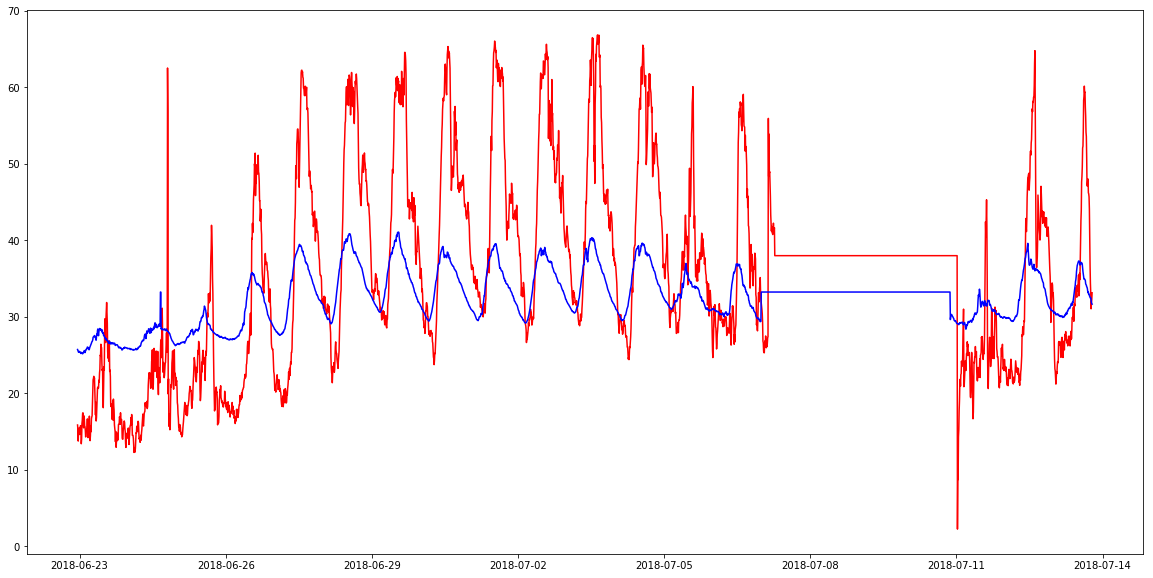

In [37]:
plt.figure(figsize=(20,10))
plt.plot(y_train_pred,'r-',y_train['temp'],'b-')

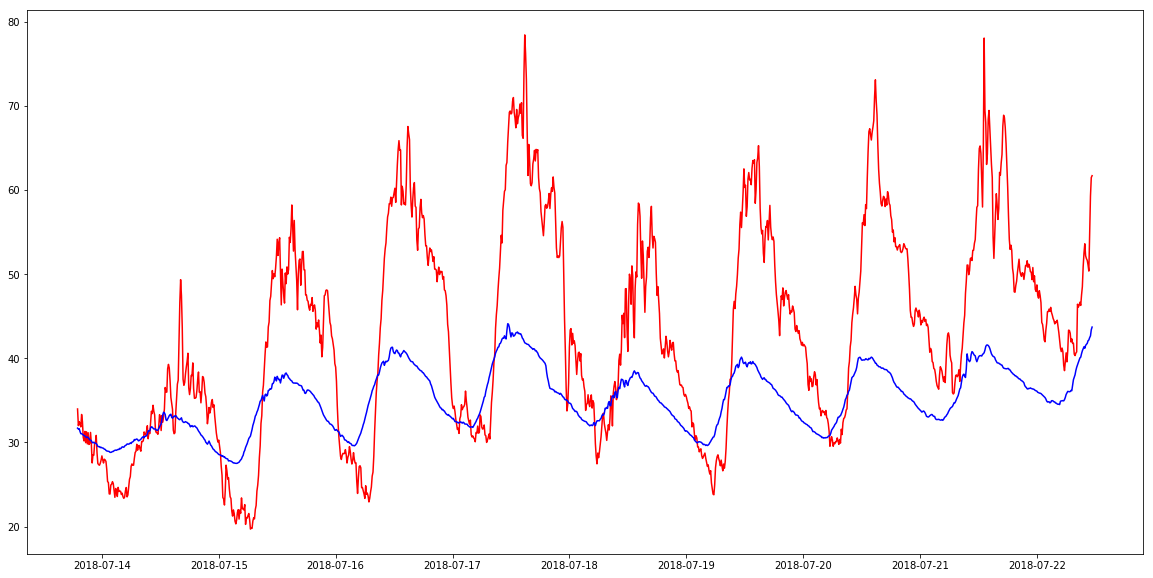

In [38]:
plt.figure(figsize=(20,10))
plt.plot(y_test_pred,'r-',y_test['temp'],'b-')